In [1]:
import sklearn
import matplotlib.pyplot as plt
from training.sigopt_utils import build_sigopt_name
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import random
from pymatgen.core import Structure
from inference.select_best_models import get_experiment_id


/home/jypeng/miniconda3/envs/Perovskite_ML_Environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_if_rocksalt(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if abs(dist-4.0)<0.1 and struct.species[j]==struct.species[i]:
                    return False
                
    return True

def get_is_rocksalt(df):
    is_rocksalt = []
    
    for i in range(len(df)):
        is_rocksalt.append(check_if_rocksalt(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_rocksalt


def check_if_layered(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
                        
            if count_NN != 2 or count_Next_NN != 1:
                return False
                
    return True

def get_is_layered(df):
    is_layered = []
    
    for i in range(len(df)):
        is_layered.append(check_if_layered(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_layered


def check_if_column(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
    
            if count_NN != 1 or count_Next_NN != 1:
                return False
                
    return True

def get_is_column(df):
    is_col = []
    
    for i in range(len(df)):
        is_col.append(check_if_column(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_col

In [3]:
def get_np_embedding(df):
    curr_embeddings = df["embedding_0"]
    
    arr_list = []
    for embedding in curr_embeddings:
        arr_list.append(np.asarray(embedding[0]))
    np_embedding = np.asarray(arr_list)
    
    return np_embedding

In [4]:
def get_rs_vec(embeddings,pca):
    
    rs_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_rocksalt:
                rs_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = rs_pos - ref/5.0
        
        rs_vec.append(curr_dist)
        
        
    rs_vec = np.asarray(rs_vec)
    return rs_vec
    
    
def get_layered_vec(embeddings,pca):
    lay_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_layered"] = get_is_layered(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_layered:
                lay_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = lay_pos - ref/5.0
        
        lay_vec.append(curr_dist)
        
        
    lay_vec = np.asarray(lay_vec)
    return lay_vec

def get_col_vec(embeddings,pca):
    col_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_column"] = get_is_column(embeddings)
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        #print(curr_embeddings.is_column)
        
        #ref = projection.mean(axis=0)
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_column:
                col_pos = projection[i,:]
            else:
                ref += projection[i,:]
            
        curr_dist = col_pos - ref/5.0
        
        col_vec.append(curr_dist)
        
        
    col_vec = np.asarray(col_vec)
    return col_vec
    

In [44]:

from matplotlib.patches import FancyArrowPatch

def embeddings_from_file(model_params,test):
    target_prop = "dft_e_hull"
    
    idx = 0
    exp_id = get_experiment_id(model_params, "dft_e_hull")
    sigopt_name = build_sigopt_name(model_params["data"], target_prop, model_params["struct_type"], model_params["interpolation"], model_params["model_type"],contrastive_weight=model_params["contrastive_weight"],training_fraction=model_params["training_fraction"])
    directory = "./best_models/" + param["model_type"] + "/" + sigopt_name + "/" +str(exp_id) + "/" + "best_" + str(idx)
    
    data = pd.read_json(directory + '/' + test + "_embeddings"+"_"+str(0)+".json")
    return data




def get_pca(param,test,num_comps=5,star_rocksalt=True,square_layered=True,rs_heatmap=True):
    
    if test == "holdout_set_B_sites":
        rs_heatmap=False
    embeddings = embeddings_from_file(param,test)
    np_embedding = get_np_embedding(embeddings)
    
    pca = PCA(n_components=2)
    pca.fit(np_embedding)
    projection = pca.transform(np_embedding)
    
    random.seed(0)
    selected_forms = random.sample(list(embeddings["formula"]), num_comps)
    selected_colors = []
    projection_featured = []
    projection_rs_ordering = []
    projection_lay_ordering = []
    projection_col_ordering = []
    
    for i in range(len(selected_forms)):
        curr_form = selected_forms[i]
        
        
        filtered_embeddings = embeddings[embeddings["formula"]==curr_form]
        filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
        filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
        filtered_embeddings["is_column"] = get_is_column(filtered_embeddings)
        
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        curr_rs_ordering = list(filtered_embeddings["is_rocksalt"])
        curr_lay_ordering = list(filtered_embeddings["is_layered"])
        curr_col_ordering = list(filtered_embeddings["is_column"])
        
        projection_featured.append(curr_projection)
        projection_rs_ordering.append(curr_rs_ordering)
        projection_lay_ordering.append(curr_lay_ordering)
        projection_col_ordering.append(curr_col_ordering)
        
        curr_color = np.ones(curr_projection.shape[0])*i
        selected_colors.append(curr_color)
        
    
    background_embeddings = embeddings[~embeddings["formula"].isin(selected_forms)]
    np_background_embeddings = get_np_embedding(background_embeddings)
    projection_background = pca.transform(np_background_embeddings)
    
    if not rs_heatmap:
        plt.scatter(projection_background[:,0],projection_background[:,1],c="black",alpha=0.03)
        for i in range(len(projection_featured)):
            has_found = False
            if star_rocksalt and square_layered:
                for j in range(len(projection_featured[i][:,0])):
                    if not projection_rs_ordering[i][j] and not projection_lay_ordering[i][j] and not has_found:
                        curr_label = selected_forms[i]
                        has_found = True
                    else:
                        curr_label = None
                    if projection_rs_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='*',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")
                    elif projection_lay_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='s',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")
                    #elif projection_col_ordering[i][j]:
                    #    plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='P',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8)
                    else:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],s=40,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")

            else:
                plt.scatter(projection_featured[i][:,0],projection_featured[i][:,1],c=selected_colors[i],label=selected_forms[i],vmin=0.0,vmax=num_comps,alpha=0.8)
                
                
        size = (projection[:,0].max()-projection[:,0].min())*0.04
        
        x_pos = projection[:,0].max() - projection[:,0].min()
        
        y_pos = projection[:,1].max() - projection[:,1].min()
        
        if param["model_type"] == "CGCNN":
        
            a = 1
    
        else:
            
            net_rs = get_rs_vec(embeddings,pca).mean(axis=0)

            net_layered = get_layered_vec(embeddings,pca).mean(axis=0)
            
            x_start = x_pos*0.70 + projection[:,0].min()
            y_start = y_pos*0.45+projection[:,1].min()
            dx = net_rs[0]
            dy = net_rs[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            x_start = x_pos*0.15 + projection[:,0].min()
            y_start = y_pos*0.15 +projection[:,1].min()
            dx = net_layered[0]
            dy = net_layered[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            
        plt.gca().set_box_aspect(1)
        
        plt.xlabel("PCA Component 1",size = 15)
        plt.ylabel("PCA Component 2",size = 15)
        plt.legend(bbox_to_anchor=(1.02, 1))
        plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.savefig("figures/embedding_"+param["model_type"]+".pdf",bbox_inches="tight")
        plt.show()

        

    if rs_heatmap:
        embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
        np_embedding = get_np_embedding(embeddings)
        projection = pca.transform(np_embedding)
        class_labels = []
        for i in range(len(embeddings)):
            if embeddings.iloc[i].is_rocksalt:
                class_labels.append(1)
            else:
                class_labels.append(0)
        class_labels = np.asarray(class_labels)
        
        x = projection[:,0]
        y = projection[:,1]
        
        bins_x = np.linspace(min(x), max(x), num=25)
        bins_y = np.linspace(min(y), max(y), num=25)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=(bins_x, bins_y))

        class_probabilities = np.zeros((len(bins_x) - 1, len(bins_y) - 1))

        for i in range(len(bins_x) - 1):
            for j in range(len(bins_y) - 1):
                mask = (x >= bins_x[i]) & (x < bins_x[i + 1]) & (y >= bins_y[j]) & (y < bins_y[j + 1])
                if np.sum(mask) > 0:
                    bin_class_prob = np.mean(class_labels[mask])
                    class_probabilities[i, j] = bin_class_prob
                else:
                    # If there are no data points in this bin, set the class probability to NaN
                    class_probabilities[i, j] = np.nan

        # Create the heatmap plot based on class probabilities with a single colormap
        cmap = plt.get_cmap('viridis')
        cmap.set_bad(color='white')  # Set color for bins with no data to white

        plt.imshow(class_probabilities.T, extent=(bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]), origin='lower', cmap=cmap, vmin=0, vmax=0.8)
        plt.colorbar(label='Class Probability')
        plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)

        plt.show()
        
        np_embedding_filt = get_np_embedding(embeddings[embeddings["is_rocksalt"]==True])
        projection_filt = pca.transform(np_embedding_filt)
        plt.scatter(projection[:,0],projection[:,1],alpha=0.2)
        plt.scatter(projection_filt[:,0],projection_filt[:,1],alpha=0.2)
        
        print(projection_filt.shape[0]/projection.shape[0])
        plt.show()

    
    
    

In [45]:
all_params = [
{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "CGCNN",
    "contrastive_weight":1.0,
    "training_fraction":1.0
},
    
    

{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "e3nn",
    "contrastive_weight":1.0,
    "training_fraction":1.0
},
    
]

all_tests = ["test_set","holdout_set_B_sites"]

/tmp/ipykernel_860933/3081046204.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

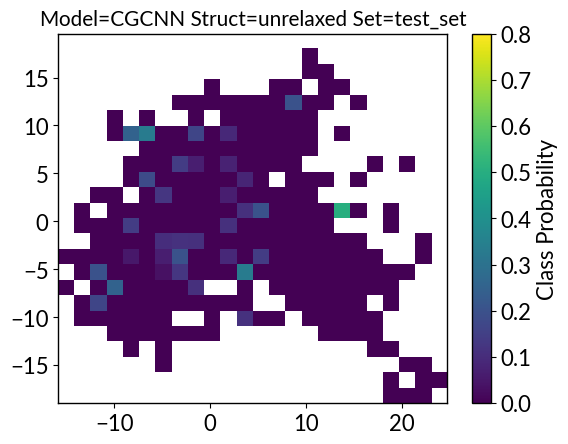

0.03647898493259318


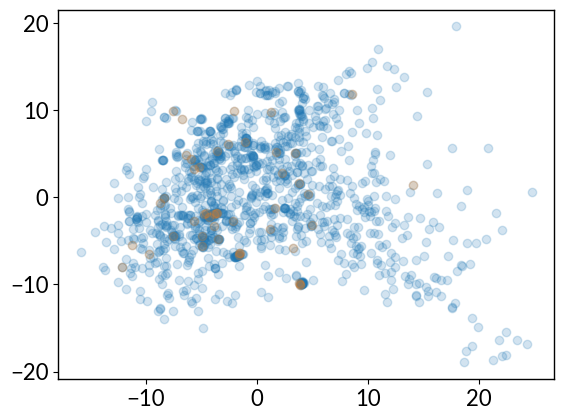

/tmp/ipykernel_860933/3081046204.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

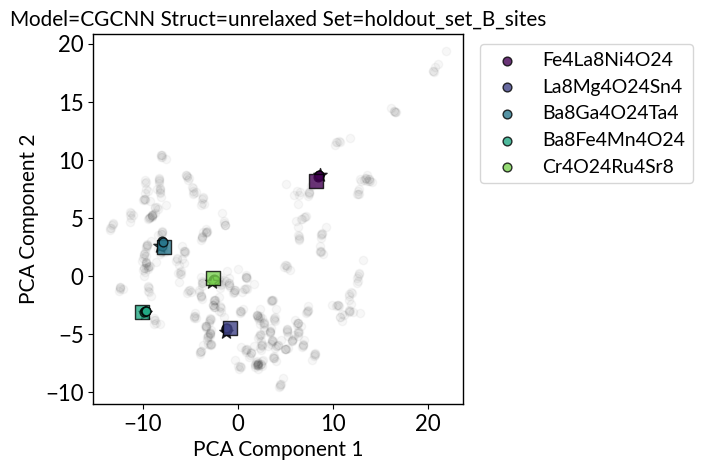

/tmp/ipykernel_860933/3081046204.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

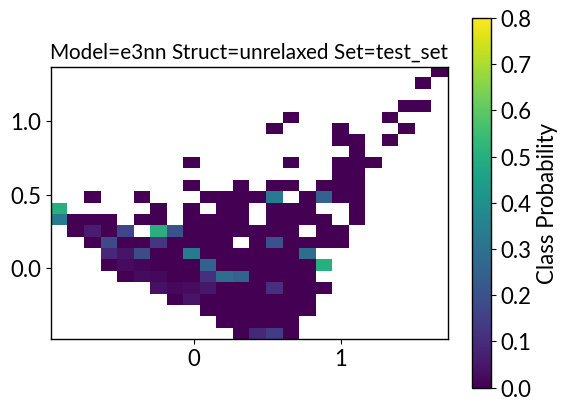

0.03647898493259318


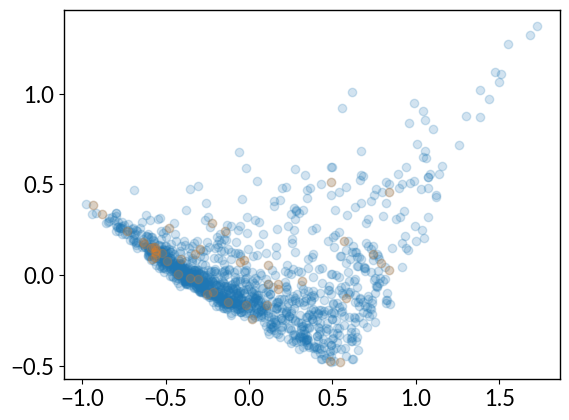

/tmp/ipykernel_860933/3081046204.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_860933/3081046204.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

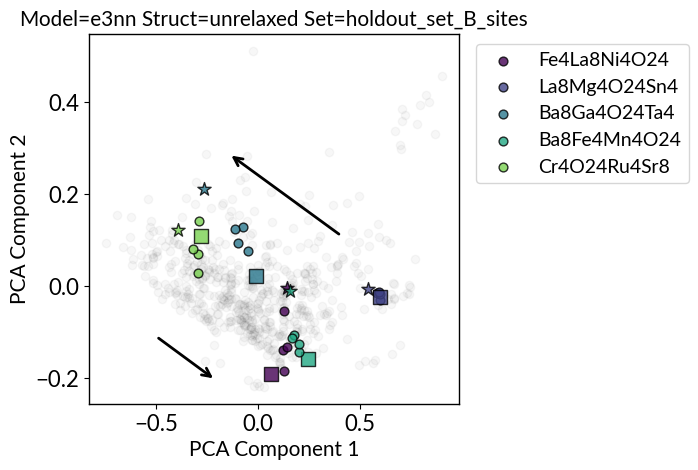

In [46]:
for param in all_params:
    for test in all_tests:
        get_pca(param,test)

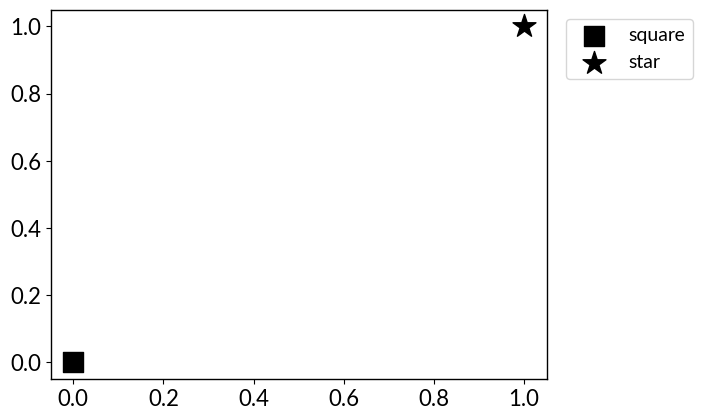

In [63]:
plt.scatter(0,0,marker="s",color="black",label="square",s = 200)
plt.scatter(1,1,marker="*",color="black",label="star",s=300)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.savefig("figures/Star_ref.pdf",bbox_inches="tight")
plt.show()